In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
# from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, make_scorer
# from sklearn.model_selection import KFold

# from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
np.random.seed(7)

# metrics

In [ ]:
def mae(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    y_pred = y_pred.reshape(1, -1)[0]
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return (f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def score(y_val, pred):
    f_value =  fscore(y_val, pred)
    mae_value = maeOverFscore(y_val, pred)
    print(f"fscore        : {f_value}")
    print(f"maeOverFscore : {mae_value}")
    
    return (f_value, mae_value)

def maeOverFscore_lgb(y_true, y_pred):
    return "maeOverFscore", mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07), False

def fscore_lgb(y_true, y_pred):
    return "fscore", fscore(y_true, y_pred), False

# data load

In [3]:
base = os.getcwd()
data_path = os.path.join(base, 'data')
submit_path = os.path.join(base, 'submit')
model_path = os.path.join(base, 'model')

def load_data(name):
    return np.load(os.path.join(data_path, f"{name}.npy"))

def reshape(data):
    return data.reshape(data.shape[0] * 40 * 40, data.shape[-1])

In [4]:
data = reshape(load_data('dl_train'))

# seperate dataset

In [5]:
X = data[:, :-1]
Y = data[:,  -1].reshape(data.shape[0], 1)
data = range(data.shape[0])
print(X.shape, Y.shape)

(121561600, 14) (121561600, 1)


# K-Fold

In [ ]:
kfold = KFold(n_splits=4, random_state=7, shuffle=False)
scores = list()

for i, (train_idx, val_idx) in enumerate(kfold.split(data)):
    clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                            n_estimators=10000, subsample_for_bin=200000, objective=None, class_weight=None, \
                            min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                            subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                            random_state=7, n_jobs=- 1, silent=True, importance_type='split')
    

    clf.fit(X[train_idx, :], Y[train_idx, 0], eval_set=[(X[val_idx, :], Y[val_idx, 0])], \
            eval_metric=["MAE", "MSE"], \
            early_stopping_rounds=50, \
            verbose=True)
    
#     clf.booster_.save_model('clf.txt')
    
    scores.append(score(clf.predict(X[val_idx, :]), Y[val_idx, :]))

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# LGBMRegressor

In [6]:
clf = lgb.LGBMRegressor(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.01, \
                        n_estimators=800, subsample_for_bin=200000, objective=None, class_weight=None, \
                        min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                        subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                        random_state=7, n_jobs=- 1, silent=True, importance_type='split')

In [7]:
clf.fit(X, Y, verbose=True)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=800, n_jobs=-1, num_leaves=31, objective=None,
              random_state=7, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# 시각화

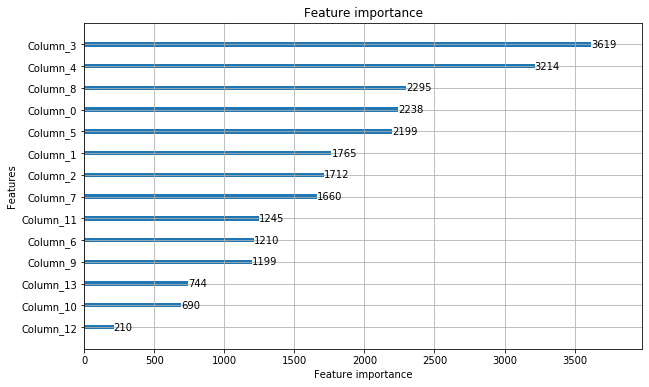

In [8]:
fig, ax = plt.subplots(figsize=(10,6))
lgb.plot_importance(clf, ax)

# 제출

In [9]:
def submit(clf, name, preprocess=None):
    x_test = reshape(load_data('test'))
    
    pred = clf.predict(x_test)

    submission = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))
    submission.iloc[:, 1:] = pred.reshape(-1, 1600)

    submission.to_csv(os.path.join(submit_path, f'{name}.csv'), index=False)

In [10]:
submit(clf, 'lightbgm_all_31_800')

- https://dacon.io/competitions/official/235591/mysubmission/
- D:\인공지능_공모전\github\submit